In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import joblib
import numpy as np

cnn = tf.keras.models.load_model("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/EnsembleNiT_cnn.h5")
cae = tf.keras.models.load_model("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/EnsembleNiT_cae.h5", custom_objects={'mse': tf.keras.losses.mse})
scaler = joblib.load("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/EnsembleNiT_scaler.pkl")
xgb = joblib.load("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/EnsembleNiT_xgb.pkl")
rf  = joblib.load("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/EnsembleNiT_rf.pkl")

/usr/lib/python3.12/pickle.py:1760: UserWarning: [09:00:29] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [3]:
encoder = tf.keras.models.Model(cae.input, cae.get_layer("latent").output)
feature_model = tf.keras.models.Model(cnn.input, cnn.get_layer("bottleneck").output)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

TEST_DIR = "/content/drive/MyDrive/Brain Tumor /TestSet_BrainTumor"

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)
X_test_feats = feature_model.predict(test_gen, verbose=1)
y_test = test_gen.classes
X_test_scaled = scaler.transform(X_test_feats)
Z_test = encoder.predict(X_test_scaled)
p_xgb = xgb.predict_proba(Z_test)
p_rf  = rf.predict_proba(Z_test)

final_prob = 0.6*p_xgb + 0.4*p_rf
final_pred = np.argmax(final_prob, axis=1)

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 515s 390ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_true = test_gen.classes
cnn_probs = cnn.predict(test_gen)
cnn_pred = np.argmax(cnn_probs, axis=1)
p_xgb = xgb.predict_proba(Z_test)
p_rf  = rf.predict_proba(Z_test)

final_prob = 0.6 * p_xgb + 0.4 * p_rf
final_pred = np.argmax(final_prob, axis=1)
def metrics(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec  = recall_score(y_true, y_pred, average="weighted")
    f1   = f1_score(y_true, y_pred, average="weighted")
    return acc, prec, rec, f1
vgg_acc, vgg_p, vgg_r, vgg_f = metrics(y_true, cnn_pred)
nit_acc, nit_p, nit_r, nit_f = metrics(y_true, final_pred)
print("VGG16 Baseline")
print("Accuracy :", vgg_acc)
print("Precision:", vgg_p)
print("Recall   :", vgg_r)
print("F1-score :", vgg_f)

print("\nHDF-Net(Proposed)")
print("Accuracy :", nit_acc)
print("Precision:", nit_p)
print("Recall   :", nit_r)
print("F1-score :", nit_f)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step
VGG16 Baseline
Accuracy : 0.977116704805492
Precision: 0.9772036049597362
Recall   : 0.977116704805492
F1-score : 0.9771269897675061

HDF-Net(Proposed)
Accuracy : 0.9839816933638444
Precision: 0.9842453240176042
Recall   : 0.9839816933638444
F1-score : 0.9839702510705706


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def predict_mri(image_path):
    # 1. Load & preprocess image
    img = load_img(image_path, target_size=(224,224))
    arr = img_to_array(img)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)

    # 2. CNN probability (end-to-end VGG16)
    cnn_probs = cnn.predict(arr)

    # 3. Extract deep CNN features (256-D)
    cnn_features = feature_model.predict(arr)

    # 4. Scale features (same scaler used during training)
    cnn_features_scaled = scaler.transform(cnn_features)

    # 5. Compress via CAE encoder → 32-D latent
    latent = encoder.predict(cnn_features_scaled)

    # 6. ML probabilities
    xgb_probs = xgb.predict_proba(latent)
    rf_probs  = rf.predict_proba(latent)

    # 7. Weighted probability fusion
    final_probs = 0.4 * cnn_probs + 0.4 * xgb_probs + 0.2 * rf_probs

    # 8. Final decision
    pred_class = np.argmax(final_probs)
    confidence = np.max(final_probs) * 100

    # 9. Display
    plt.imshow(img)
    plt.title(f"{class_names[pred_class]} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    return class_names[pred_class], confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


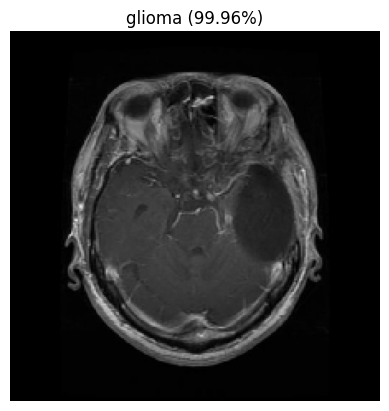

('glioma', np.float64(99.96088862419128))

In [6]:
class_indices = test_gen.class_indices
class_names = [None] * len(class_indices)
for name, idx in class_indices.items():
    class_names[idx] = name
predict_mri("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/Te-gl_0015.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


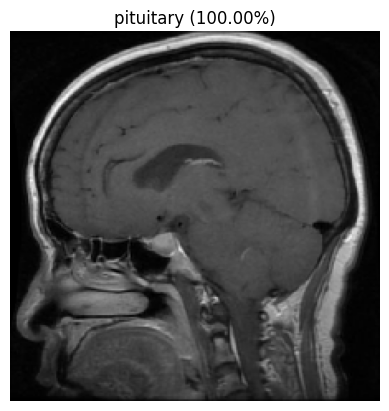

('pituitary', np.float64(99.99914884567261))

In [7]:
predict_mri("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/Te-piTr_0003.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


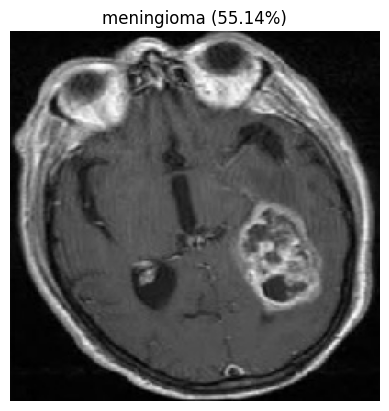

('meningioma', np.float64(55.138772853215535))

In [8]:
predict_mri("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/Te-meTr_0001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


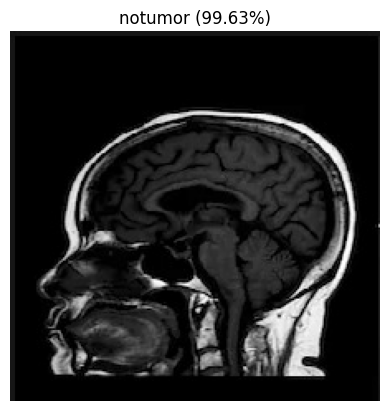

('notumor', np.float64(99.63479161262512))

In [9]:
predict_mri("/content/drive/MyDrive/3rd_year_project-PR_591/Brain_tumor_detection/Te-noTr_0004.jpg")